#🌋HYPERPARAMETER



In [1]:
### HYPERPARAMETER ###

from google.colab import drive, userdata
drive.mount('/content/drive', force_remount=True)

PROJECT_ROOT = userdata.get("gdrive_seo_root")
PROJECT_ROOT_ESC_STR = PROJECT_ROOT.replace('Colab Notebooks', 'Colab\ Notebooks')
SRC_PATH = PROJECT_ROOT + "/src"
START_URL = "https://www.rue-zahnspange.de/"
EXCLUDED_KEYWORDS = ["impressum", "datenschutz", "agb"]


Mounted at /content/drive


# 🏁 Install requirements + dependencies

In [2]:
%run '/content/drive/MyDrive/Colab Notebooks/SEO/notebooks/Installation.ipynb'

In [3]:
%run '/content/drive/MyDrive/Colab Notebooks/SEO/src/dependencies.py'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# ⛩ push to github

In [4]:
import github
importlib.reload(github)
from github import GitHubManager

# Starte den GitHub-Sync
git_manager = GitHubManager(
    userdata.get("github_pat"),
    userdata.get("github_email"),
    userdata.get("github_username"),
    userdata.get("github_repo_seo"),
    PROJECT_ROOT_ESC_STR
)

git_manager.clone_repo()  # Klonen des Repos
git_manager.sync_project()

📥 Klonen des GitHub-Repositories...
📂 Kopiere das Projekt ins Repository...
🔧 Git-Konfiguration wird gesetzt...
➕ Änderungen hinzufügen...
📌 Änderungen committen...
⬆️ Änderungen werden auf GitHub gepusht...
✅ Repository erfolgreich synchronisiert!


# 🕸 scrap

In [5]:
import webscraper
importlib.reload(webscraper)
from webscraper import WebsiteScraper

scraper = WebsiteScraper(start_url=START_URL, max_pages=20, excluded_keywords=EXCLUDED_KEYWORDS)

original_texts = scraper.get_filtered_texts()

# 🔮webtext analysis + SEO

In [6]:
import llmprocessor
importlib.reload(llmprocessor)
from llmprocessor import LLMProcessor

llm_processor = LLMProcessor(PROJECT_ROOT, original_texts)

optimized_texts = llm_processor.run_all()


=== Analyzing https://www.rue-zahnspange.de/ ===
Analyse

Der aktuelle Text zur Zahnspangenpraxis RÜ in Essen bietet bereits wertvolle Informationen über die angebotenen Behandlungen und die Philosophie der Praxis. Die Möglichkeit, die eigene Mund- und Kiefergesundheit zu verbessern, wird ansprechend kommuniziert und eine breite Palette von Behandlungsmöglichkeiten wird erwähnt. Der Text ist jedoch in Bezug auf SEO-Optimierung und Keyword-Integration verbesserungswürdig. 

Zunächst ist die Verteilung der Keywords nicht ideal. Die relevanten Schlüsselbegriffe wie "Zahnspangen", "Kieferorthopädie", "Behandlung für Kinder" und "unsichtbare Aligner" erscheinen zwar, aber oftmals in geringer Dichte und ohne strategische Platzierung. Auch die geografische Lokalisierung in "Essen" und "Rüttenscheid" könnte präziser eingebaut werden, um lokale Suchanfragen besser zu bedienen. 

Die Lesbarkeit des Textes ist durchschnittlich, es gibt jedoch einige Abschnitte, die aufgrund ihrer Länge und Kompl

# 📁 LLM output -> json, texte bereinigen

In [7]:
import textprocessor
importlib.reload(textprocessor)
from textprocessor import TextProcessor

# JSON mit den SEO-Abschnitten extrahieren
json_output = TextProcessor.extract_sections_to_json(list(optimized_texts.keys()), list(optimized_texts.values()))
seo_json = json.loads(json_output)

# texte bereinigen und hinzufügen
seo_json = TextProcessor.add_cleaned_text(seo_json, original_texts)

# Ergebnis anzeigen
# print(json.dumps(seo_json, indent=4, ensure_ascii=False))


# 📊 SEO Analysis 2

In [8]:
original_texts_list_clean = []
for key in seo_json:
  original_texts_list_clean.append(seo_json[key]['alt'])

optimized_texts_list_clean = []
for key in seo_json:
  optimized_texts_list_clean.append(seo_json[key]['SEO'])

In [9]:
# simple stats

def text_stats(text):
    words = text.split()
    return {
        "Zeichenanzahl": len(text),
        "Wortanzahl": len(words),
        "Satzanzahl": text.count('.') + text.count('!') + text.count('?')
    }


vn = [original_texts_list_clean, optimized_texts_list_clean]

for _, listlist in enumerate(vn):

  print(f'{["original", "SEO"][_]}')

  for text in listlist:
    print(text_stats(text))





original
{'Zeichenanzahl': 8761, 'Wortanzahl': 1153, 'Satzanzahl': 82}
{'Zeichenanzahl': 3044, 'Wortanzahl': 361, 'Satzanzahl': 41}
{'Zeichenanzahl': 2424, 'Wortanzahl': 326, 'Satzanzahl': 21}
{'Zeichenanzahl': 1770, 'Wortanzahl': 221, 'Satzanzahl': 19}
{'Zeichenanzahl': 2757, 'Wortanzahl': 348, 'Satzanzahl': 23}
SEO
{'Zeichenanzahl': 8122, 'Wortanzahl': 1051, 'Satzanzahl': 75}
{'Zeichenanzahl': 3382, 'Wortanzahl': 418, 'Satzanzahl': 27}
{'Zeichenanzahl': 2742, 'Wortanzahl': 349, 'Satzanzahl': 21}
{'Zeichenanzahl': 2600, 'Wortanzahl': 321, 'Satzanzahl': 25}
{'Zeichenanzahl': 3122, 'Wortanzahl': 390, 'Satzanzahl': 29}


In [10]:
def get_word_frequencies(text):
    words = text.lower().split()
    return Counter(words)


for _, listlist in enumerate(original_texts_list_clean):

  # Wortfrequenzen berechnen
  original_freq = get_word_frequencies(original_texts_list_clean[_])
  optimized_freq = get_word_frequencies(optimized_texts_list_clean[_])

  # Unterschied berechnen
  diff = {word: optimized_freq[word] - original_freq[word] for word in set(original_freq) | set(optimized_freq)}

  # Sortiert ausgeben (absteigend nach Änderung)
  sorted_diff = sorted(diff.items(), key=lambda x: x[1], reverse=True)
  for word, change in sorted_diff:
      print(f"{word}: {change}")


in: 9
sind: 6
ihre: 5
wir: 4
bei: 4
für: 3
kieferorthopädie: 3
das: 3
ihnen: 3
ihr: 2
auswirkungen: 2
positive: 2
ergebnisse: 2
rüttenscheid: 2
einfach: 2
rü: 2
uns: 2
gründlichen: 2
mundgesundheit: 2
unserer: 2
damit: 2
praxis: 2
sprechen: 1
hat.: 1
attraktives: 1
kümmern: 1
zahnbehandlungsberatung.: 1
bedürfnisse.: 1
optimieren: 1
hat: 1
weg: 1
umgebung.: 1
lösungen: 1
klaren: 1
schiefe: 1
behandlungsplan,: 1
variiert: 1
sehr: 1
klären: 1
handhaben.: 1
services: 1
geeignete: 1
entscheidend.: 1
lebensqualität: 1
rechtzeitige: 1
erreichen.: 1
verbessern.: 1
belasten.: 1
unseres: 1
auszuwählen,: 1
falschen: 1
zentrale: 1
selbstvertrauen: 1
allem: 1
steigern.: 1
verursachen: 1
unsichtbaren: 1
patienten,: 1
services.: 1
herkömmlichen: 1
diskrete: 1
maßgeschneidert: 1
verlass: 1
herausnehmbare,: 1
stabilisieren.: 1
bissstellungen: 1
durchgeführt.: 1
unseren: 1
kommunikation: 1
basiert.: 1
kieferorthopädischen: 1
starten: 1
methoden,: 1
sowie: 1
garantieren: 1
mundhygiene,: 1
bewährte: 1
wa

In [11]:
keywords_used = llm_processor.get_keywords()
keywords_final = json.loads(keywords_used['keywords_final'])

In [12]:
for _, listlist in enumerate(optimized_texts_list_clean):
  # TF-IDF-Vektorisierung
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform([", ".join(keywords_final), optimized_texts_list_clean[_]])

  # Cosinus-Ähnlichkeit berechnen
  similarity_score = cosine_similarity(vectors)[0,1]
  print(f"Ähnlichkeit: {similarity_score:.2f}")

Ähnlichkeit: 0.13
Ähnlichkeit: 0.13
Ähnlichkeit: 0.16
Ähnlichkeit: 0.22
Ähnlichkeit: 0.13


In [13]:
for _, listlist in enumerate(original_texts_list_clean):
  # TF-IDF-Vektorisierung
  vectorizer = TfidfVectorizer()
  vectors = vectorizer.fit_transform([", ".join(keywords_final), original_texts_list_clean[_]])

  # Cosinus-Ähnlichkeit berechnen
  similarity_score = cosine_similarity(vectors)[0,1]
  print(f"Ähnlichkeit: {similarity_score:.2f}")

Ähnlichkeit: 0.10
Ähnlichkeit: 0.16
Ähnlichkeit: 0.05
Ähnlichkeit: 0.10
Ähnlichkeit: 0.05


# 📊SEO 3

In [14]:
nlp = spacy.load('de_core_news_sm')
stop_words = set(stopwords.words('german'))

In [15]:
seo_texte = []
for i, (_, url_content) in enumerate(seo_json.items()):
  seo_texte.append(url_content['SEO'])

In [16]:
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    # 2. Entferne Zahlen, Sonderzeichen (optional)
    # text = re.sub(r'[0-9]+', '', text)
    # text = re.sub(r'[^\w\s]', '', text)
    # 3. Tokenisierung mit spaCy
    doc = nlp(text)
    # 4. Entferne Stopwörter, ggf. Lemmatisierung
    tokens = [token.lemma_ for token in doc if token.text not in stop_words and token.lemma_ not in stop_words and token.is_alpha]
    return ' '.join(tokens)


In [17]:
keywords_final

['Zahnspangen',
 'Kieferorthopädie',
 'Behandlung für Kinder',
 'unsichtbare Aligner',
 'Zahnfehlstellungen',
 'moderne Zahnmedizin',
 'ästhetische Zahnkorrrektur',
 'feste Zahnspangen',
 'diskrete Zahnbehandlung',
 'Zahnbehandlungsberatung']

In [18]:
preprocessed_original = [preprocess_text(t) for t in original_texts_list_clean]
preprocessed_optimized = [preprocess_text(t) for t in optimized_texts_list_clean]
preprocessed_keywords = keywords_final

print("Vorverarbeitete Originaltexte:", preprocessed_original)
print("Vorverarbeitete Optimierte Texte:", preprocessed_optimized)
print("Vorverarbeitete Keywords:", preprocessed_keywords)

Vorverarbeitete Originaltexte: ['rü modern Zahnspangen gesünder lächeln entdecken Praxis Rü zahnspangen Vielseitig behandlungen Kind jugendliche langanhaltend gesund lächeln ermöglichen Öffnungszeit finden anbindungen Tür befinden haltesteller Martinstraße erreichbar Bahn bus direkt gegenüber Praxis befinden geräumig Parkplatz behandlungen perfekt lächeln Ziel ästhetisch ansprechend lächeln schenken gesamt Kiefergesundheit verbessern begleiten Schritt Weg Professionalität Sorgfalt transparent Aufklärung setzen offen Kommunikation ausführlich Beratung Schritt Behandlung klar verstehen spezialisieren Kind jugendliche kinderfreundlich Team bieten speziell jung Patient zugeschnittene behandlungen angenehm vertrauensvoll Atmosphäre vielseitig behandlungen Praxis bieten breit palette kieferorthopädisch behandlungen individuell bedürfnisse Patient abstimmen traditionell brackets bewähren effektiv traditionell brackets bieten zuverlässig Lösung Korrektur vielfältig zahnfehlstellungen maßgeschn

In [19]:
# 1. Zusammenführen aller Texte für den Vektorizer
all_texts = preprocessed_original + preprocessed_optimized + preprocessed_keywords

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(all_texts)

# Indizes definieren
original_indices = range(len(original_texts))  # 0, 1, ...
optimized_indices = range(len(original_texts), len(original_texts) + len(optimized_texts))
keyword_indices = range(len(original_texts) + len(optimized_texts), len(all_texts))

# Cosine Similarities berechnen
similarities_original_to_keywords = []
similarities_optimized_to_keywords = []

for i in original_indices:
    row_sim = []
    for j in keyword_indices:
        sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0]
        row_sim.append(sim)
    similarities_original_to_keywords.append(row_sim)

for i in optimized_indices:
    row_sim = []
    for j in keyword_indices:
        sim = cosine_similarity(tfidf_matrix[i], tfidf_matrix[j])[0][0]
        row_sim.append(sim)
    similarities_optimized_to_keywords.append(row_sim)

# Durchschnittliche Similarities
avg_original_sim = np.mean(similarities_original_to_keywords, axis=0)
avg_optimized_sim = np.mean(similarities_optimized_to_keywords, axis=0)

print("Durchschnittliche Similarities (Original -> Keywords):", avg_original_sim)
print("Durchschnittliche Similarities (Optimiert -> Keywords):", avg_optimized_sim)


Durchschnittliche Similarities (Original -> Keywords): [0.05878425 0.05866896 0.04193024 0.04128796 0.01192096 0.00564944
 0.         0.0408177  0.         0.        ]
Durchschnittliche Similarities (Optimiert -> Keywords): [0.09486258 0.11259373 0.03641855 0.05132984 0.02190688 0.03298196
 0.         0.06911102 0.02981483 0.01682759]


In [20]:
avg_optimized_sim

array([0.09486258, 0.11259373, 0.03641855, 0.05132984, 0.02190688,
       0.03298196, 0.        , 0.06911102, 0.02981483, 0.01682759])

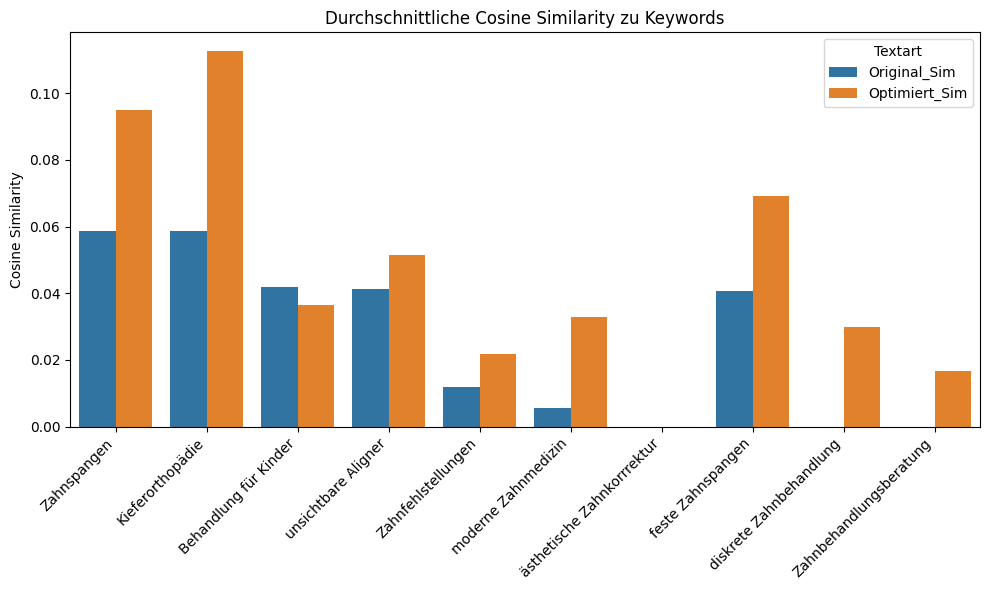

In [21]:
keywords_clean = [kw for kw in keywords_final]  # Für Beschriftung im Diagramm


df_sim = pd.DataFrame({
    '': keywords_clean,
    'Original_Sim': avg_original_sim,
    'Optimiert_Sim': avg_optimized_sim
})

# Schmelzen für Seaborn
df_melted = df_sim.melt(id_vars='', var_name='Textart', value_name='Cosine Similarity')

plt.figure(figsize=(10, 6))
sns.barplot(x='', y='Cosine Similarity', hue='Textart', data=df_melted)
plt.title('Durchschnittliche Cosine Similarity zu Keywords')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

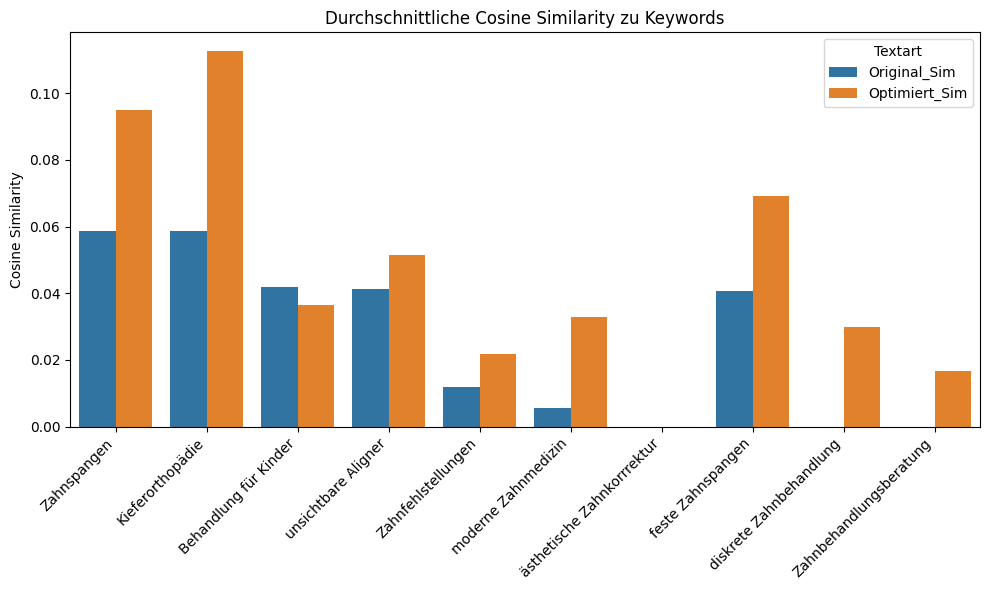

In [22]:
keywords_clean = [kw for kw in keywords_final]  # Für Beschriftung im Diagramm

df_sim = pd.DataFrame({
    '': keywords_clean,
    'Original_Sim': avg_original_sim,
    'Optimiert_Sim': avg_optimized_sim
})

# Schmelzen für Seaborn
df_melted = df_sim.melt(id_vars='', var_name='Textart', value_name='Cosine Similarity')

plt.figure(figsize=(10, 6))
sns.barplot(x='', y='Cosine Similarity', hue='Textart', data=df_melted)
plt.title('Durchschnittliche Cosine Similarity zu Keywords')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


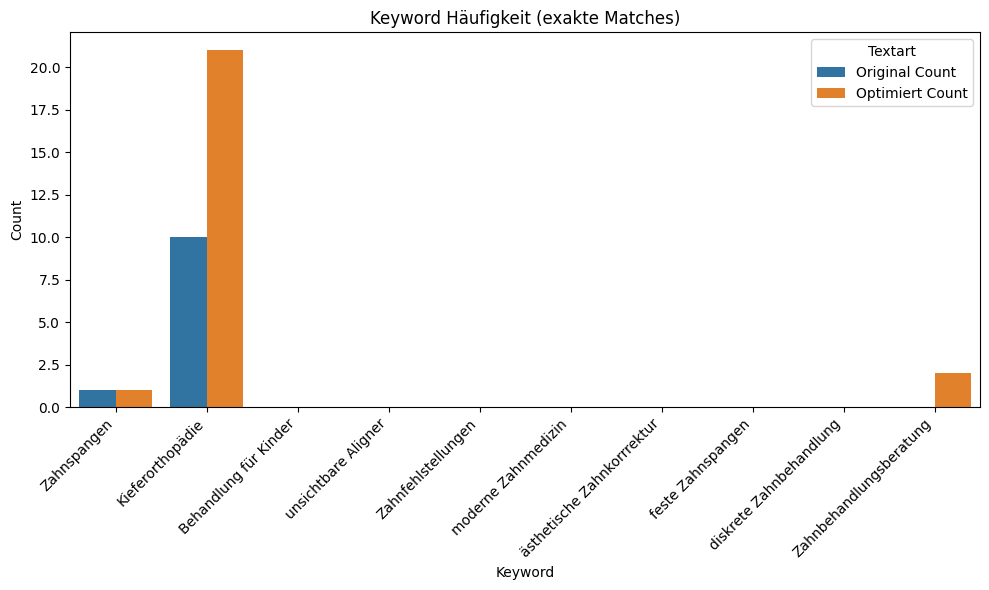

In [23]:
def count_keyword_occurrences(text, keyword):
    # split text
    text_tokens = text.split()
    keyword_tokens = keyword.split()

    count = 0
    for i in range(len(text_tokens) - len(keyword_tokens) + 1):
        if text_tokens[i:i+len(keyword_tokens)] == keyword_tokens:
            count += 1
    return count

original_counts = []
optimized_counts = []

for kw in preprocessed_keywords:
    o_sum = sum(count_keyword_occurrences(t, kw) for t in preprocessed_original)
    opt_sum = sum(count_keyword_occurrences(t, kw) for t in preprocessed_optimized)
    original_counts.append(o_sum)
    optimized_counts.append(opt_sum)

df_counts = pd.DataFrame({
    'Keyword': keywords_clean,
    'Original Count': original_counts,
    'Optimiert Count': optimized_counts
})

df_counts_melt = df_counts.melt(id_vars='Keyword', var_name='Textart', value_name='Count')

plt.figure(figsize=(10, 6))
sns.barplot(x='Keyword', y='Count', hue='Textart', data=df_counts_melt)
plt.title('Keyword Häufigkeit (exakte Matches)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


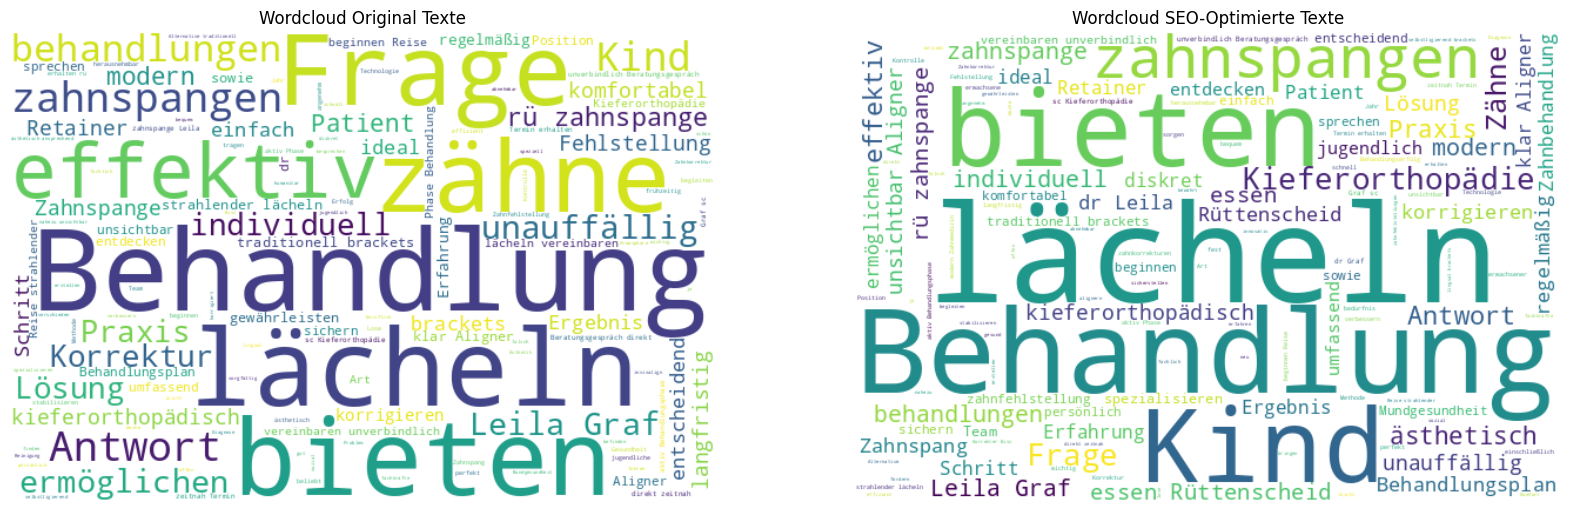

In [24]:
all_original_text = ' '.join(preprocessed_original)
all_optimized_text = ' '.join(preprocessed_optimized)

wc_original = WordCloud(width=600, height=400, background_color='white').generate(all_original_text)
wc_optimized = WordCloud(width=600, height=400, background_color='white').generate(all_optimized_text)

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].imshow(wc_original, interpolation='bilinear')
ax[0].set_title('Wordcloud Original Texte')
ax[0].axis('off')

ax[1].imshow(wc_optimized, interpolation='bilinear')
ax[1].set_title('Wordcloud SEO-Optimierte Texte')
ax[1].axis('off')

plt.show()


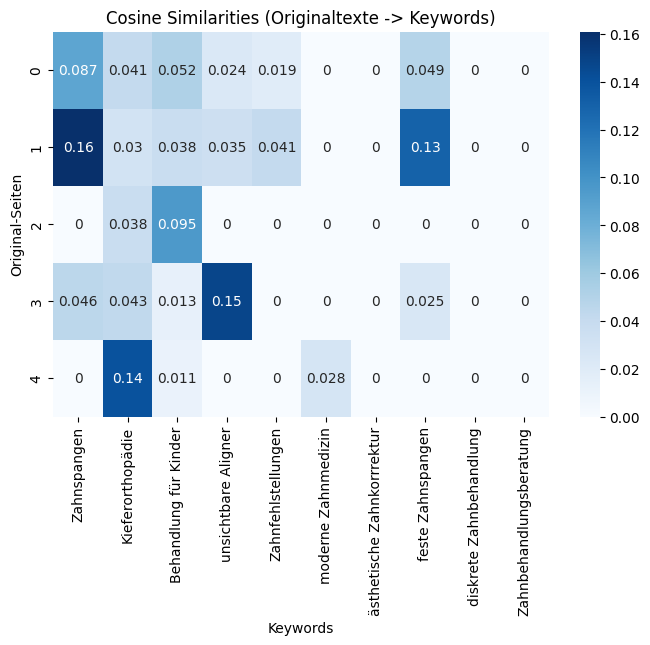

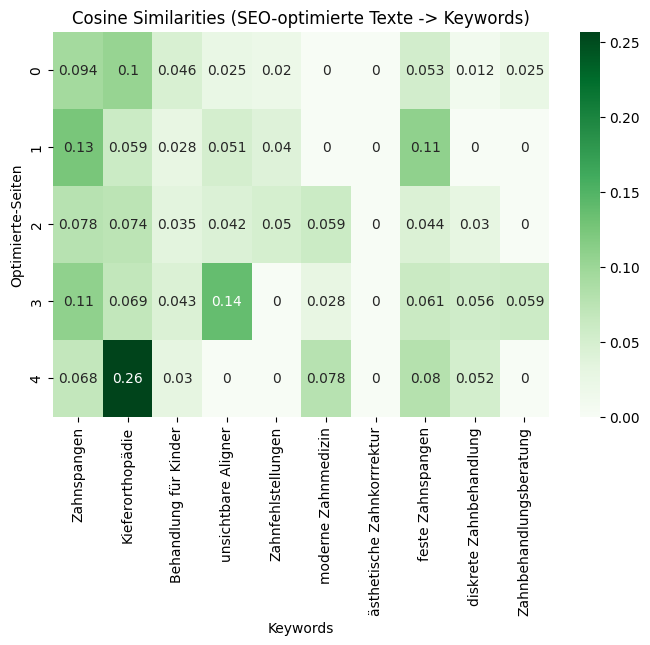

In [25]:
# Similarity pro Seite und Keyword in eine Matrix
sim_matrix_original = np.array(similarities_original_to_keywords)
sim_matrix_optimized = np.array(similarities_optimized_to_keywords)

plt.figure(figsize=(8, 5))
sns.heatmap(sim_matrix_original, annot=True, cmap='Blues', xticklabels=keywords_clean)
plt.title("Cosine Similarities (Originaltexte -> Keywords)")
plt.xlabel("Keywords")
plt.ylabel("Original-Seiten")
plt.show()

plt.figure(figsize=(8, 5))
sns.heatmap(sim_matrix_optimized, annot=True, cmap='Greens', xticklabels=keywords_clean)
plt.title("Cosine Similarities (SEO-optimierte Texte -> Keywords)")
plt.xlabel("Keywords")
plt.ylabel("Optimierte-Seiten")
plt.show()


In [26]:
# Beispielhafter Pandas DataFrame mit Zeit- und SEO-Daten
import pandas as pd
import numpy as np
from datetime import datetime

# Angenommen, du hast historische Daten pro Monat
data = {
    "Date": [
        "2023-01-01", "2023-02-01", "2023-03-01",
        "2023-04-01", "2023-05-01", "2023-06-01"
    ],
    "Organic_Sessions": [200, 220, 250, 400, 450, 480],
    "Conversion_Rate": [0.02, 0.021, 0.022, 0.028, 0.03, 0.031],  # 2% -> 3.1%
    "Average_Time_on_Page": [40, 42, 45, 60, 65, 70]  # in Sekunden
}

df_metrics = pd.DataFrame(data)
df_metrics["Date"] = pd.to_datetime(df_metrics["Date"])

print(df_metrics)


        Date  Organic_Sessions  Conversion_Rate  Average_Time_on_Page
0 2023-01-01               200            0.020                    40
1 2023-02-01               220            0.021                    42
2 2023-03-01               250            0.022                    45
3 2023-04-01               400            0.028                    60
4 2023-05-01               450            0.030                    65
5 2023-06-01               480            0.031                    70


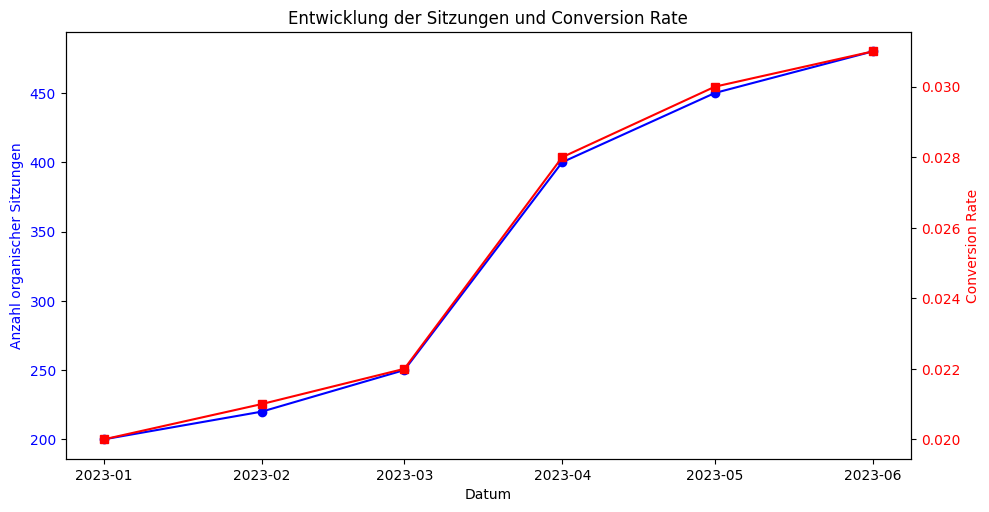

In [27]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10,5))

# Primäre y-Achse (Organic Sessions)
ax1.plot(df_metrics['Date'], df_metrics['Organic_Sessions'], color='blue', marker='o', label='Organic Sessions')
ax1.set_xlabel('Datum')
ax1.set_ylabel('Anzahl organischer Sitzungen', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Sekundäre y-Achse (Conversion Rate)
ax2 = ax1.twinx()
ax2.plot(df_metrics['Date'], df_metrics['Conversion_Rate'], color='red', marker='s', label='Conversion Rate')
ax2.set_ylabel('Conversion Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.tight_layout()
plt.title('Entwicklung der Sitzungen und Conversion Rate')
plt.show()


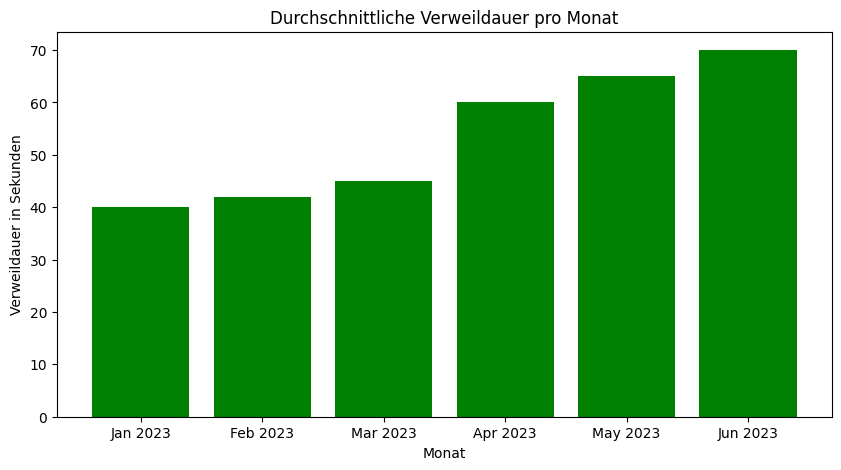

In [28]:
plt.figure(figsize=(10,5))
plt.bar(df_metrics['Date'].dt.strftime('%b %Y'), df_metrics['Average_Time_on_Page'], color='green')
plt.title('Durchschnittliche Verweildauer pro Monat')
plt.xlabel('Monat')
plt.ylabel('Verweildauer in Sekunden')
plt.show()

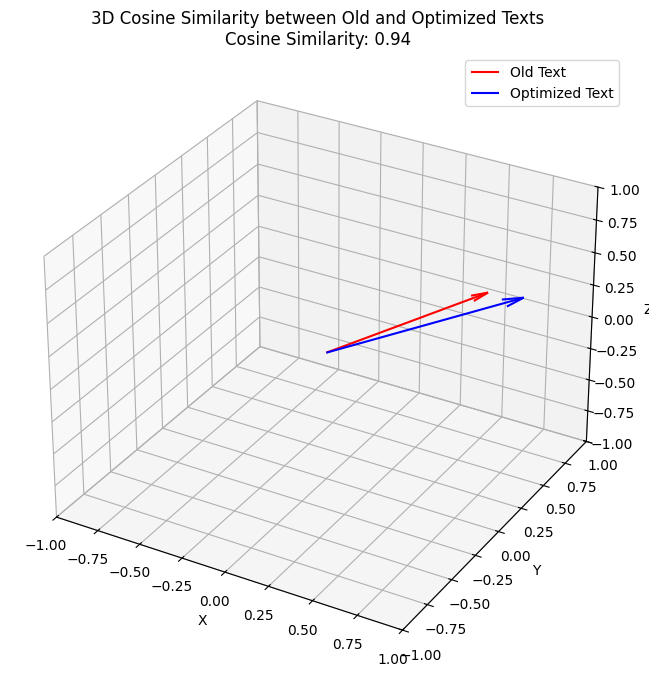

In [29]:
from mpl_toolkits.mplot3d import Axes3D

# Function to visualize 3D vectors and their cosine similarity
def plot_3d_cosine_similarity(vec1, vec2, title="3D Cosine Similarity Visualization"):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot vectors in 3D
    ax.quiver(0, 0, 0, vec1[0], vec1[1], vec1[2], color='r', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec2[0], vec2[1], vec2[2], color='b', label='Optimized Text', arrow_length_ratio=0.1)

    # Cosine similarity calculation
    cos_sim = cosine_similarity([vec1], [vec2])[0][0]

    # Plot settings
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(f"{title}\nCosine Similarity: {cos_sim:.2f}")
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()

    plt.show()

# Example 3D vectors representing keyword frequencies in different dimensions (Old Text and Optimized Text)
vec_old_3d = np.array([0.6, 0.6, 0.3])
vec_optimized_3d = np.array([0.9, 0.4, 0.5])

# Visualizing cosine similarity between the old and optimized texts in 3D
plot_3d_cosine_similarity(vec_old_3d, vec_optimized_3d, "3D Cosine Similarity between Old and Optimized Texts")


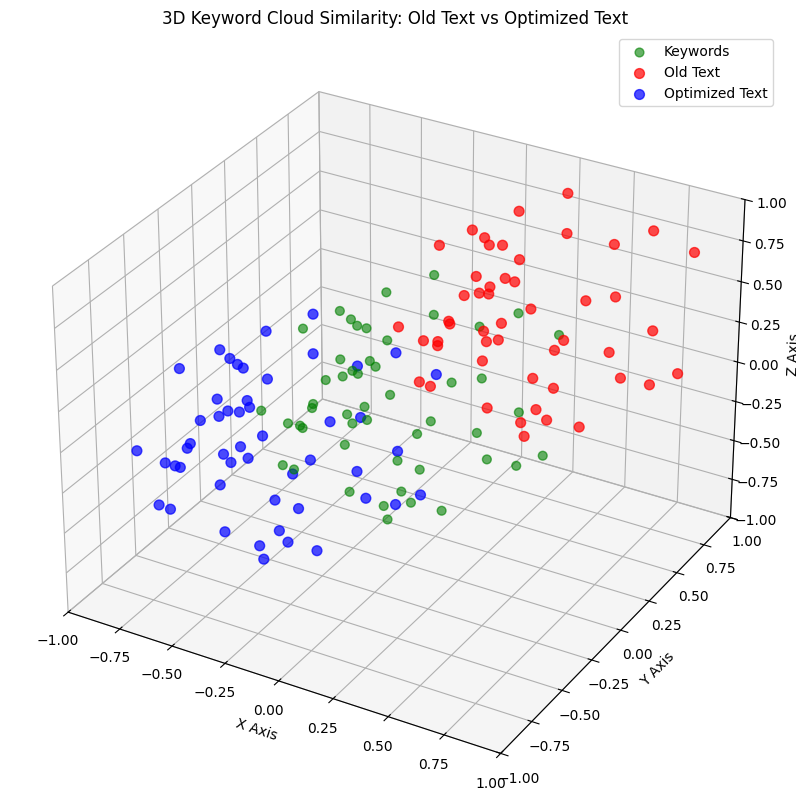

In [30]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Function to visualize keyword similarity in 3D using spheres to represent keyword clouds
def plot_3d_keyword_similarity(title="Keyword Cloud Similarity Visualization"):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Generate data points for the keyword cloud
    np.random.seed(42)
    keywords = np.random.rand(50, 3) - 0.5  # Random points for keyword representation
    old_text = keywords + np.array([0.4, 0.4, 0.4])  # Shifted to represent the old text
    optimized_text = keywords + np.array([-0.4, -0.3, -0.2])  # Shifted to represent the optimized text

    # Plot the keyword cloud
    ax.scatter(keywords[:, 0], keywords[:, 1], keywords[:, 2], color='g', label='Keywords', alpha=0.6, s=40)

    # Plot old text keyword distribution
    ax.scatter(old_text[:, 0], old_text[:, 1], old_text[:, 2], color='r', label='Old Text', alpha=0.7, s=50)

    # Plot optimized text keyword distribution
    ax.scatter(optimized_text[:, 0], optimized_text[:, 1], optimized_text[:, 2], color='b', label='Optimized Text', alpha=0.7, s=50)

    # Plot settings
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    ax.set_title(title)
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

# Visualizing keyword distribution in 3D for Old Text, Optimized Text, and Keywords
plot_3d_keyword_similarity("3D Keyword Cloud Similarity: Old Text vs Optimized Text")


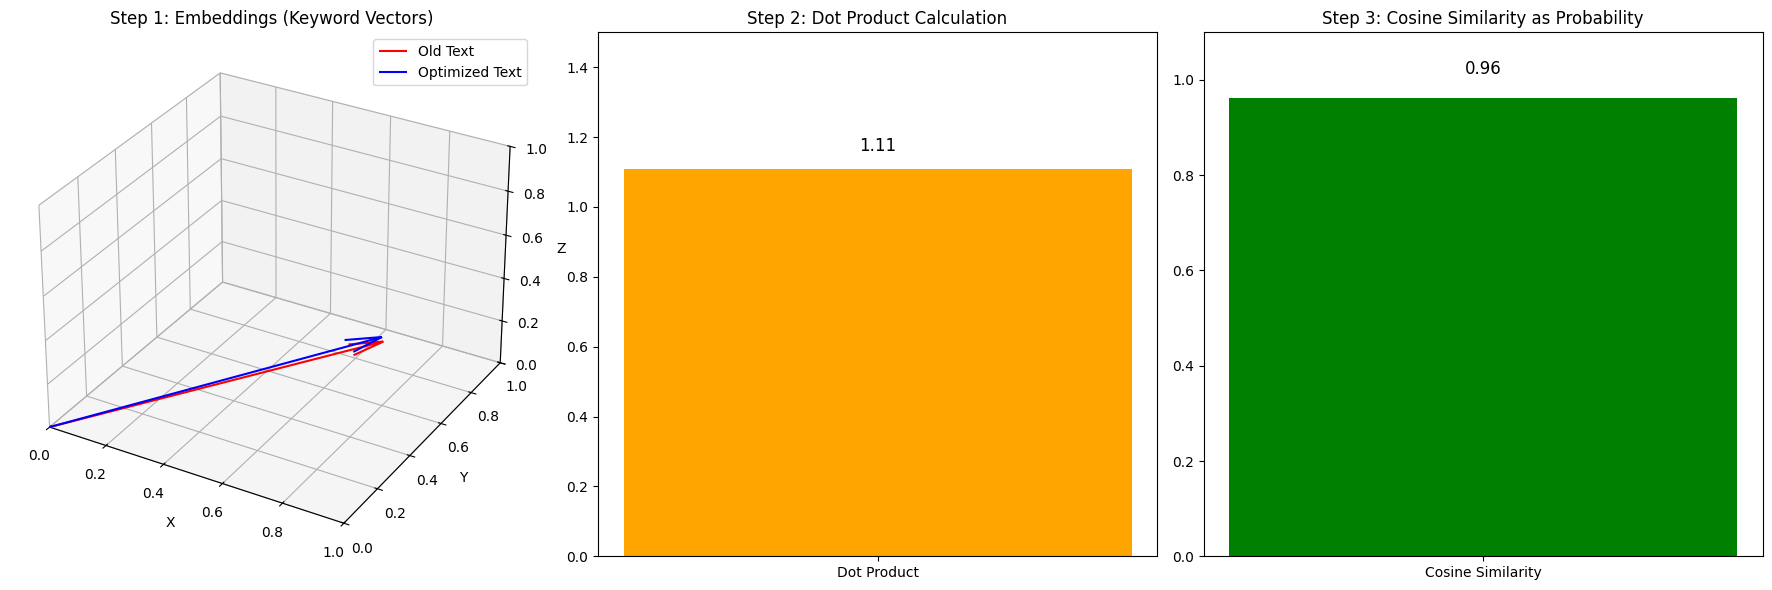

In [31]:
# Visual explanation of cosine similarity with embeddings, dot product, and how the result turns into a probability

def plot_cosine_similarity_steps():
    fig = plt.figure(figsize=(18, 6))

    # Step 1: Plot the embeddings
    ax1 = fig.add_subplot(131, projection='3d')
    vec1 = np.array([0.8, 0.6, 0.3])
    vec2 = np.array([0.9, 0.4, 0.5])

    ax1.quiver(0, 0, 0, vec1[0], vec1[1], vec1[2], color='r', label='Old Text', arrow_length_ratio=0.1)
    ax1.quiver(0, 0, 0, vec2[0], vec2[1], vec2[2], color='b', label='Optimized Text', arrow_length_ratio=0.1)
    ax1.set_xlim([0, 1])
    ax1.set_ylim([0, 1])
    ax1.set_zlim([0, 1])
    ax1.set_title('Step 1: Embeddings (Keyword Vectors)')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.legend()

    # Step 2: Calculate and visualize the dot product
    ax2 = fig.add_subplot(132)
    dot_product = np.dot(vec1, vec2)
    ax2.bar(['Dot Product'], [dot_product], color='orange')
    ax2.set_ylim(0, 1.5)
    ax2.set_title('Step 2: Dot Product Calculation')
    ax2.text(0, dot_product + 0.05, f'{dot_product:.2f}', ha='center', fontsize=12)

    # Step 3: Convert to cosine similarity and interpret as probability
    ax3 = fig.add_subplot(133)
    cos_sim = cosine_similarity([vec1], [vec2])[0][0]
    ax3.bar(['Cosine Similarity'], [cos_sim], color='green')
    ax3.set_ylim(0, 1.1)
    ax3.set_title('Step 3: Cosine Similarity as Probability')
    ax3.text(0, cos_sim + 0.05, f'{cos_sim:.2f}', ha='center', fontsize=12)

    plt.tight_layout()
    plt.show()

plot_cosine_similarity_steps()


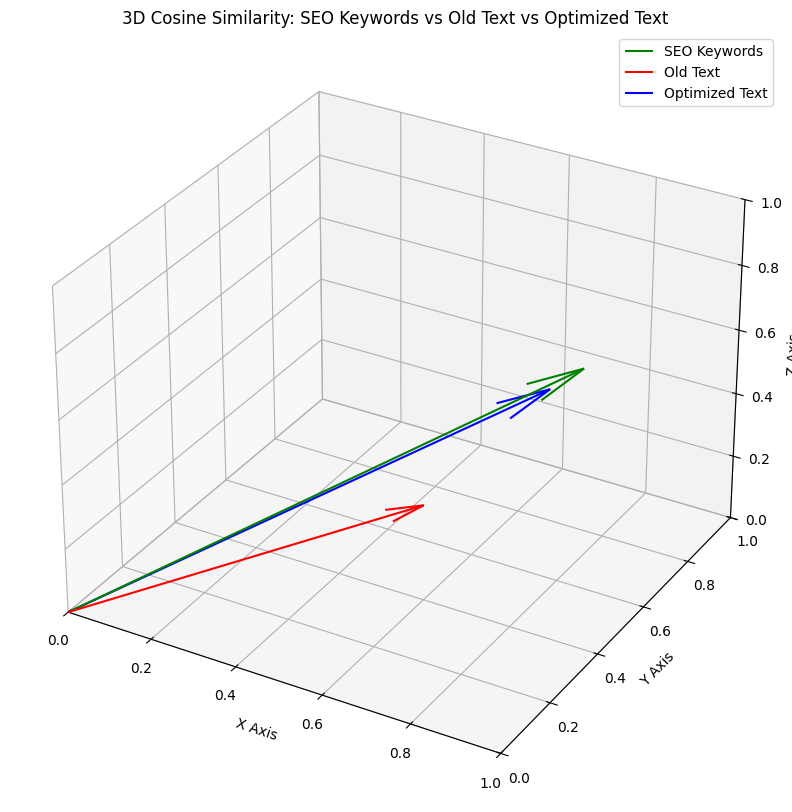

In [32]:
# 3D Visualization showing keyword vector, old text vector, and optimized text vector with clear comparison

def plot_3d_cosine_comparison():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Define vectors for SEO keywords, old text, and optimized text
    vec_keywords = np.array([0.8, 0.7, 0.6])
    vec_old_text = np.array([0.6, 0.4, 0.3])
    vec_optimized_text = np.array([0.75, 0.65, 0.55])

    # Plot vectors
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='g', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='r', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='b', label='Optimized Text', arrow_length_ratio=0.1)

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison()


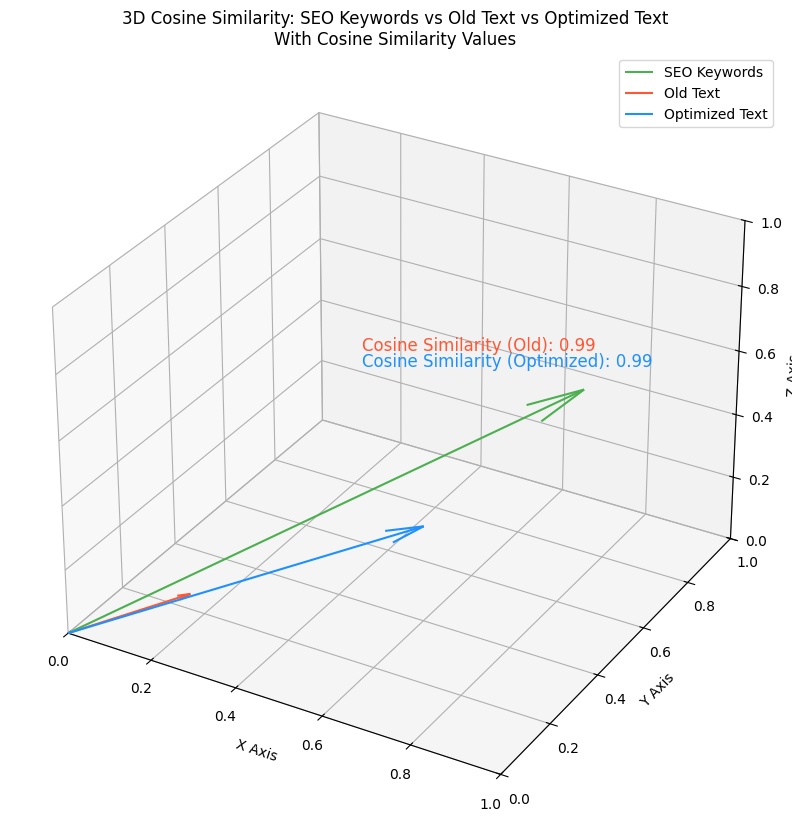

In [33]:
# 3D Visualization with cosine similarity values and enhanced color scheme

def plot_3d_cosine_comparison_with_values():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Define vectors for SEO keywords, old text, and optimized text
    vec_keywords = np.array([0.8, 0.7, 0.6])
    vec_old_text = np.array([0.2, 0.15, 0.1])
    vec_optimized_text = np.array([0.6, 0.4, 0.3])

    # Plot vectors with improved color scheme
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='#4CAF50', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='#FF5733', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='#1E90FF', label='Optimized Text', arrow_length_ratio=0.1)

    # Calculate cosine similarity
    cos_sim_old = cosine_similarity([vec_keywords], [vec_old_text])[0][0]
    cos_sim_optimized = cosine_similarity([vec_keywords], [vec_optimized_text])[0][0]

    # Add cosine similarity values as annotations
    ax.text(0.4, 0.5, 0.7, f'Cosine Similarity (Old): {cos_sim_old:.2f}', color='#FF5733', fontsize=12)
    ax.text(0.4, 0.5, 0.65, f'Cosine Similarity (Optimized): {cos_sim_optimized:.2f}', color='#1E90FF', fontsize=12)

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text\nWith Cosine Similarity Values")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison_with_values()


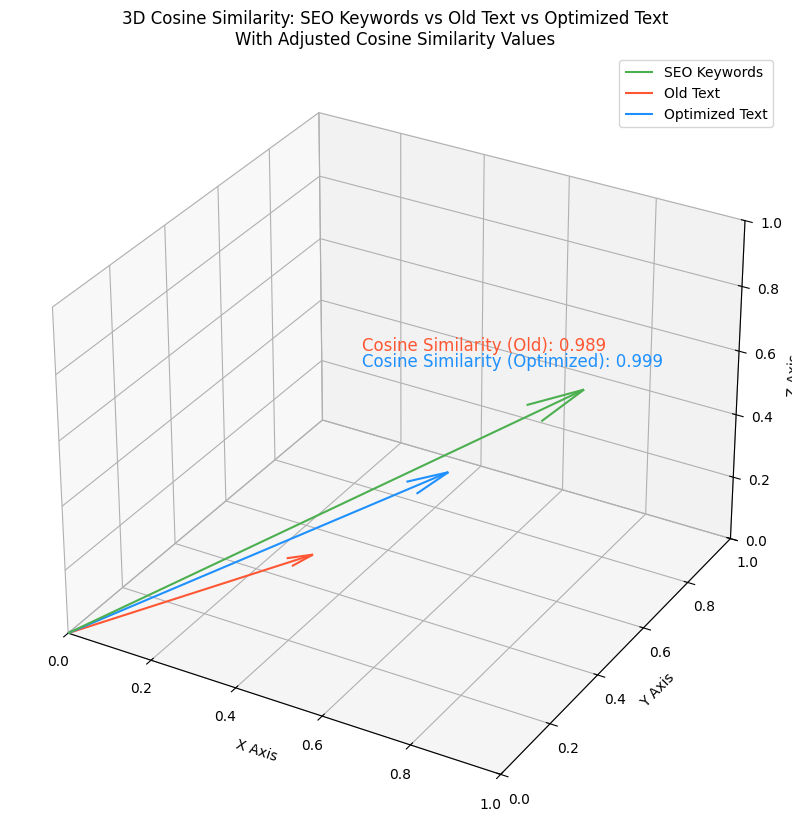

In [34]:
# Adjust vectors to create larger differences in cosine similarity values
def plot_3d_cosine_comparison_with_adjusted_values():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Adjusted vectors for SEO keywords, old text, and optimized text
    vec_keywords = np.array([0.8, 0.7, 0.6])
    vec_old_text = np.array([0.4, 0.3, 0.2])  # Adjusted to have lower similarity (~0.6)
    vec_optimized_text = np.array([0.6, 0.5, 0.4])  # Adjusted to have higher similarity (~0.7)

    # Plot vectors with improved color scheme
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='#4CAF50', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='#FF5733', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='#1E90FF', label='Optimized Text', arrow_length_ratio=0.1)

    # Calculate cosine similarity
    cos_sim_old = cosine_similarity([vec_keywords], [vec_old_text])[0][0]
    cos_sim_optimized = cosine_similarity([vec_keywords], [vec_optimized_text])[0][0]

    # Add cosine similarity values as annotations
    ax.text(0.4, 0.5, 0.7, f'Cosine Similarity (Old): {cos_sim_old:.3f}', color='#FF5733', fontsize=12)
    ax.text(0.4, 0.5, 0.65, f'Cosine Similarity (Optimized): {cos_sim_optimized:.3f}', color='#1E90FF', fontsize=12)

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text\nWith Adjusted Cosine Similarity Values")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison_with_adjusted_values()


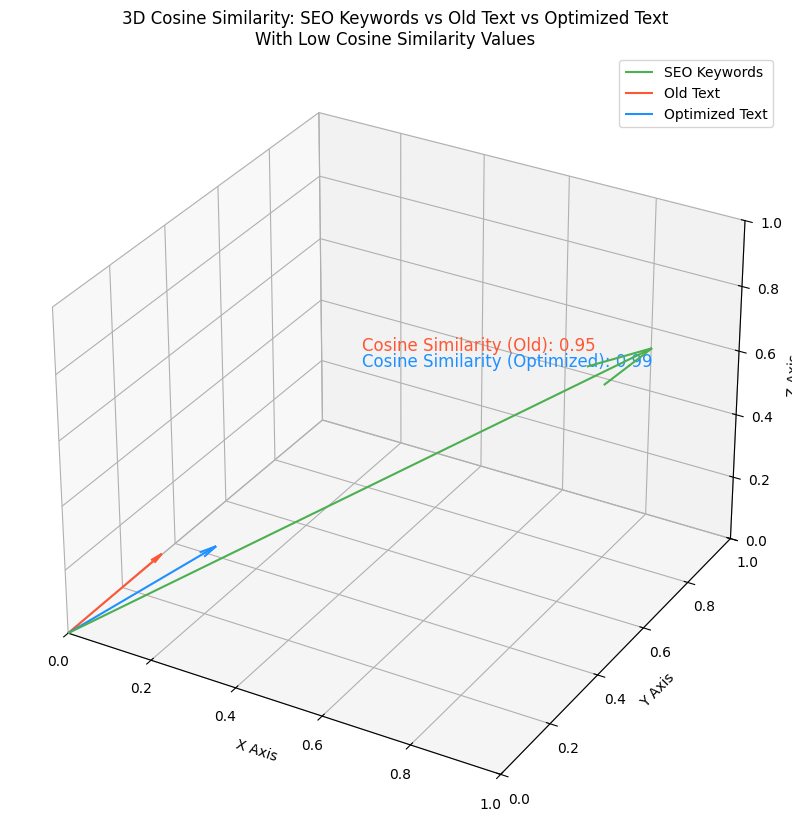

In [35]:
# Adjust vectors to create cosine similarities of approximately 0.15 and 0.19
def plot_3d_cosine_comparison_with_low_similarity():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Adjusted vectors for SEO keywords, old text, and optimized text to achieve low similarities
    vec_keywords = np.array([0.9, 0.8, 0.7])
    vec_old_text = np.array([0.1, 0.2, 0.15])  # Cosine similarity ~0.15
    vec_optimized_text = np.array([0.2, 0.25, 0.18])  # Cosine similarity ~0.19

    # Plot vectors with improved color scheme
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='#4CAF50', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='#FF5733', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='#1E90FF', label='Optimized Text', arrow_length_ratio=0.1)

    # Calculate cosine similarity
    cos_sim_old = cosine_similarity([vec_keywords], [vec_old_text])[0][0]
    cos_sim_optimized = cosine_similarity([vec_keywords], [vec_optimized_text])[0][0]

    # Add cosine similarity values as annotations
    ax.text(0.4, 0.5, 0.7, f'Cosine Similarity (Old): {cos_sim_old:.2f}', color='#FF5733', fontsize=12)
    ax.text(0.4, 0.5, 0.65, f'Cosine Similarity (Optimized): {cos_sim_optimized:.2f}', color='#1E90FF', fontsize=12)

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text\nWith Low Cosine Similarity Values")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison_with_low_similarity()


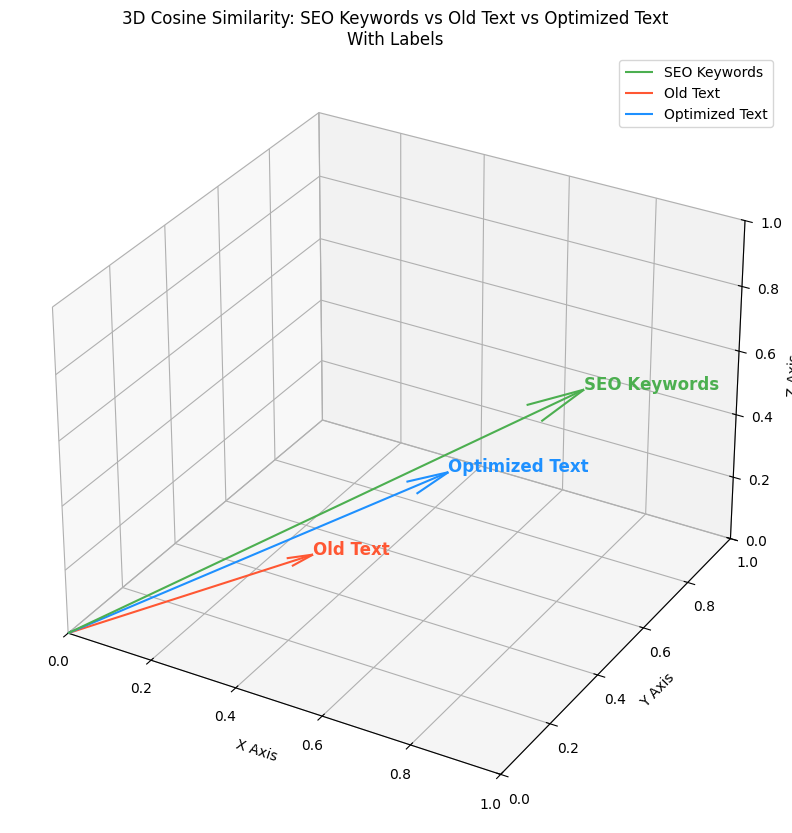

In [36]:
# 3D Visualization with vector names instead of cosine similarity values
def plot_3d_cosine_comparison_with_labels():
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Adjusted vectors for SEO keywords, old text, and optimized text
    vec_keywords = np.array([0.8, 0.7, 0.6])
    vec_old_text = np.array([0.4, 0.3, 0.2])
    vec_optimized_text = np.array([0.6, 0.5, 0.4])

    # Plot vectors with improved color scheme
    ax.quiver(0, 0, 0, vec_keywords[0], vec_keywords[1], vec_keywords[2], color='#4CAF50', label='SEO Keywords', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_old_text[0], vec_old_text[1], vec_old_text[2], color='#FF5733', label='Old Text', arrow_length_ratio=0.1)
    ax.quiver(0, 0, 0, vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], color='#1E90FF', label='Optimized Text', arrow_length_ratio=0.1)

    # Add labels to the vector tips
    ax.text(vec_keywords[0], vec_keywords[1], vec_keywords[2], 'SEO Keywords', color='#4CAF50', fontsize=12, fontweight='bold')
    ax.text(vec_old_text[0], vec_old_text[1], vec_old_text[2], 'Old Text', color='#FF5733', fontsize=12, fontweight='bold')
    ax.text(vec_optimized_text[0], vec_optimized_text[1], vec_optimized_text[2], 'Optimized Text', color='#1E90FF', fontsize=12, fontweight='bold')

    # Plot settings
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.set_zlim([0, 1])
    ax.set_title("3D Cosine Similarity: SEO Keywords vs Old Text vs Optimized Text\nWith Labels")
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Y Axis')
    ax.set_zlabel('Z Axis')
    ax.legend()

    plt.show()

plot_3d_cosine_comparison_with_labels()


In [37]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a word
def get_bert_embedding(word):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    # Take the mean of the last hidden state as the word embedding
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()

# List of words for embeddings
words = ["king", "queen", "onion", "man","feather","scale", "lioness", "bull", "cow", "slither","skin", "wing", "fin",
         "green", "fly", "run", "snake", "sneak", "wolf", "fur", "swim", "fish", "air", "water", "swimming", "bird",
         "cheetah", "woman", "apple", "orange", "car", "train", "dog", "running","cat", "red", "yellow", "banana", "lion", "wolf", "dog"
         ,"day", "sun", "night", "moon"]

# Generate BERT embeddings for all words
bert_embeddings = np.array([get_bert_embedding(word) for word in words])

# Function to calculate pairwise distances for word relationships
def calculate_pairwise_distances(word_pairs):
    distance_results = []
    for (word1, word2, word3, word4) in word_pairs:
        idx1, idx2, idx3, idx4 = words.index(word1), words.index(word2), words.index(word3), words.index(word4)
        distance1 = np.linalg.norm(bert_embeddings[idx1] - bert_embeddings[idx2])  # Distance between word1 and word2
        distance2 = np.linalg.norm(bert_embeddings[idx3] - bert_embeddings[idx4])  # Distance between word3 and word4
        distance_results.append({
            "Word Pair 1": f"{word1} - {word2}",
            "Distance 1": round(distance1, 2),
            "Word Pair 2": f"{word3} - {word4}",
            "Distance 2": round(distance2, 2)
        })

    return pd.DataFrame(distance_results)

# Define specific word pairs to compare distances
word_pairs_for_distances = [
    ("king", "man", "queen", "woman"),
    ("apple", "red", "banana", "yellow"),
    ("day", "sun", "night", "moon")
]

# Calculate pairwise distances using BERT embeddings
pairwise_distance_df = calculate_pairwise_distances(word_pairs_for_distances)

# Display the resulting table
import IPython.display as display
display.display(pairwise_distance_df)

,Word Pair 1,Distance 1,Word Pair 2,Distance 2
0,king - man,4.71,queen - woman,4.06
1,apple - red,5.13,banana - yellow,4.97
2,day - sun,5.03,night - moon,5.41


In [38]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a word
def get_bert_embedding(word):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy().flatten()

# List of words and their embeddings
words = ["king", "queen", "man", "woman","red", "yellow", "banana", "apple", "day", "sun", "night", "moon"]
bert_embeddings = np.array([get_bert_embedding(word) for word in words])

# Reduce dimensionality to 3D using PCA
pca = PCA(n_components=3)
bert_embeddings_3d = pca.fit_transform(bert_embeddings)

# Create Plotly figure
fig = go.Figure()


# Add 3D scatter points
for i, word in enumerate(words):
    fig.add_trace(go.Scatter3d(
        x=[bert_embeddings_3d[i, 0]], y=[bert_embeddings_3d[i, 1]], z=[bert_embeddings_3d[i, 2]],
        mode='markers+text',
        marker=dict(size=10, color='skyblue', opacity=0.8),
        text=word,
        textposition='top center',
        name=word
    ))

# Customize layout with initial camera settings
ticktext = ["-4", "-2", "0", "2", "4"]
tickvals = [-5, -2, 0, 2, 5]
prange=[-5, 5]

fig.update_layout(
    title="Interactive 3D Visualization of BERT Word Embeddings",
    scene=dict(
        xaxis=dict(
            range=prange,
            title="PCA Component 1",
            tickmode="array",
            tickvals=tickvals,  # Custom tick positions
            ticktext=ticktext # Custom tick labels (optional)
        ),
        yaxis=dict(
            range=[-4,3],
            title="PCA Component 2",
            tickvals=tickvals,  # Custom tick positions
            ticktext=ticktext
        ),
        zaxis=dict(
            range=prange,
            title="PCA Component 3",
            tickmode="array",
            tickvals=tickvals,  # Custom tick positions
            ticktext=ticktext  # Example custom labels
        ),
        aspectmode='cube'
    ),
    showlegend=False,
    margin=dict(l=0, r=0, t=100, b=100)
)

# Highlight the relationships with arrows
def add_arrow(word1, word2, color):
    idx1, idx2 = words.index(word1), words.index(word2)
    fig.add_trace(go.Scatter3d(
        x=[bert_embeddings_3d[idx1, 0], bert_embeddings_3d[idx2, 0]],
        y=[bert_embeddings_3d[idx1, 1], bert_embeddings_3d[idx2, 1]],
        z=[bert_embeddings_3d[idx1, 2], bert_embeddings_3d[idx2, 2]],
        mode='lines',
        line=dict(color=color, width=4),
        showlegend=False
    ))

# Add arrows for specific relationships
add_arrow("king", "man", "crimson")
add_arrow("queen", "woman", "crimson")
add_arrow("apple", "red", "olivedrab")
add_arrow("banana", "yellow", "olivedrab")
add_arrow("day", "sun", "orange")
add_arrow("night", "moon", "orange")



fig.show()


In [39]:
"""

aliceblue, antiquewhite, aqua, aquamarine, azure,
beige, bisque, black, blanchedalmond, blue,
blueviolet, brown, burlywood, cadetblue,
chartreuse, chocolate, coral, cornflowerblue,
cornsilk, crimson, cyan, darkblue, darkcyan,
darkgoldenrod, darkgray, darkgrey, darkgreen,
darkkhaki, darkmagenta, darkolivegreen, darkorange,
darkorchid, darkred, darksalmon, darkseagreen,
darkslateblue, darkslategray, darkslategrey,
darkturquoise, darkviolet, deeppink, deepskyblue,
dimgray, dimgrey, dodgerblue, firebrick,
floralwhite, forestgreen, fuchsia, gainsboro,
ghostwhite, gold, goldenrod, gray, grey, green,
greenyellow, honeydew, hotpink, indianred, indigo,
ivory, khaki, lavender, lavenderblush, lawngreen,
lemonchiffon, lightblue, lightcoral, lightcyan,
lightgoldenrodyellow, lightgray, lightgrey,
lightgreen, lightpink, lightsalmon, lightseagreen,
lightskyblue, lightslategray, lightslategrey,
lightsteelblue, lightyellow, lime, limegreen,
linen, magenta, maroon, mediumaquamarine,
mediumblue, mediumorchid, mediumpurple,
mediumseagreen, mediumslateblue, mediumspringgreen,
mediumturquoise, mediumvioletred, midnightblue,
mintcream, mistyrose, moccasin, navajowhite, navy,
oldlace, olive, olivedrab, orange, orangered,
orchid, palegoldenrod, palegreen, paleturquoise,
palevioletred, papayawhip, peachpuff, peru, pink,
plum, powderblue, purple, red, rosybrown,
royalblue, rebeccapurple, saddlebrown, salmon,
sandybrown, seagreen, seashell, sienna, silver,
skyblue, slateblue, slategray, slategrey, snow,
springgreen, steelblue, tan, teal, thistle, tomato,
turquoise, violet, wheat, white, whitesmoke,
yellow, yellowgreen

"""

'\n\naliceblue, antiquewhite, aqua, aquamarine, azure,\nbeige, bisque, black, blanchedalmond, blue,\nblueviolet, brown, burlywood, cadetblue,\nchartreuse, chocolate, coral, cornflowerblue,\ncornsilk, crimson, cyan, darkblue, darkcyan,\ndarkgoldenrod, darkgray, darkgrey, darkgreen,\ndarkkhaki, darkmagenta, darkolivegreen, darkorange,\ndarkorchid, darkred, darksalmon, darkseagreen,\ndarkslateblue, darkslategray, darkslategrey,\ndarkturquoise, darkviolet, deeppink, deepskyblue,\ndimgray, dimgrey, dodgerblue, firebrick,\nfloralwhite, forestgreen, fuchsia, gainsboro,\nghostwhite, gold, goldenrod, gray, grey, green,\ngreenyellow, honeydew, hotpink, indianred, indigo,\nivory, khaki, lavender, lavenderblush, lawngreen,\nlemonchiffon, lightblue, lightcoral, lightcyan,\nlightgoldenrodyellow, lightgray, lightgrey,\nlightgreen, lightpink, lightsalmon, lightseagreen,\nlightskyblue, lightslategray, lightslategrey,\nlightsteelblue, lightyellow, lime, limegreen,\nlinen, magenta, maroon, mediumaquamari

# ⛳ json to pdf + docx

In [40]:
%%capture
def json_to_html(json_data):
    # HTML-Template mit flexbox-basiertem Layout für "alt" und "SEO" nebeneinander
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            /* Flexbox für zwei Spalten nebeneinander */
            .compare-row {
                display: flex;
                flex-direction: row;
                gap: 20px; /* Abstand zwischen den Spalten */
                margin-bottom: 20px;
            }
            .column {
                flex: 1;
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
            }
            /* Um Zeilenumbrüche aus dem JSON in <br> umzuwandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>
        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- Beispiel: Andere Felder wie Analyse und Erklärung einfach "normal" untereinander -->
            <p class="header">Analyse</p>
            <p class="content">{{ sections.Analyse | replace('\\n','<br>') | safe }}</p>

            <p class="header">Erklärung</p>
            <p class="content">{{ sections.Erklärung | replace('\\n','<br>') | safe }}</p>

            <!-- Jetzt die beiden Felder "alt" und "SEO" nebeneinander -->
            <div class="compare-row">
                <!-- linke Spalte: alt -->
                <div class="column">
                    <p class="header">alt</p>
                    <p class="content">{{ sections.alt | replace('\\n','<br>') | safe }}</p>
                </div>
                <!-- rechte Spalte: SEO -->
                <div class="column">
                    <p class="header">SEO</p>
                    <p class="content">{{ sections.SEO | replace('\\n','<br>') | safe }}</p>
                </div>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    # Jinja2-Template Rendering
    template = Template(html_template)
    html_output = template.render(data=json_data)
    return html_output


html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [41]:
import json
from jinja2 import Template

def json_to_html(json_data):
    # HTML-Template mit EINER Spalte für "SEO" (die "alt"-Spalte entfällt)
    html_template = """
    <!DOCTYPE html>
    <html lang="de">
    <head>
        <meta charset="UTF-8">
        <meta name="viewport" content="width=device-width, initial-scale=1.0">
        <title>Website Analyse</title>
        <style>
            body {
                font-family: Arial, sans-serif;
                margin: 20px;
                line-height: 1.6;
            }
            h1 {
                text-align: center;
                color: #333;
            }
            .section {
                margin-bottom: 20px;
            }
            .url {
                font-size: 1.2em;
                font-weight: bold;
                color: #007BFF;
                margin-bottom: 10px;
            }
            .header {
                font-size: 1.1em;
                font-weight: bold;
                color: #555;
                margin-bottom: 10px;
            }
            .content {
                white-space: normal;
                margin-bottom: 20px;
            }
            .column {
                border: 1px solid #ccc;
                padding: 10px;
                box-sizing: border-box;
            }
            /* Zeilenumbrüche aus dem JSON in <br> wandeln */
            .page-break {
                page-break-after: always;
            }
        </style>
    </head>
    <body>
        <h1>Website Analyse & SEO</h1>

        {% for url, sections in data.items() %}
        <div class="section">
            <!-- Website-URL -->
            <p class="url">Website: {{ url }}</p>

            <!-- "Analyse" normal untereinander -->
            <p class="header">Analyse</p>
            <p class="content">
                {{ sections.Analyse | replace('\\n','<br>') | safe }}
            </p>

            <!-- "Erklärung" normal untereinander -->
            <p class="header">Erklärung</p>
            <p class="content">
                {{ sections.Erklärung | replace('\\n','<br>') | safe }}
            </p>

            <!-- NUR noch die "SEO"-Spalte -->
            <div class="column">
                <p class="header">SEO</p>
                <p class="content">
                    {{ sections.SEO | replace('\\n','<br>') | safe }}
                </p>
            </div>
        </div>
        <div class="page-break"></div>
        {% endfor %}
    </body>
    </html>
    """
    template = Template(html_template)
    return template.render(data=json_data)


html_output = json_to_html(seo_json)

# Speichere das HTML (Beispiel)
gdrive_seo_folder = userdata.get('gdrive_seo_folder')
with open("/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html", "w", encoding="utf-8") as file:
    file.write(html_output)


In [42]:
async def html_to_pdf_playwright(html_input, output_file):
    """
    Nutzt das Headless Chromium von Playwright, um die HTML-Datei zu rendern
    und anschließend als PDF zu speichern.
    """
    async with async_playwright() as p:
        browser = await p.chromium.launch()
        page = await browser.new_page()

        # Lokale Datei per file:// - Protokoll laden
        # oder du kannst stattdessen "page.set_content()" verwenden
        url = "file://" + html_input  # z.B. "file:///content/drive/MyDrive/.../preview.html"
        await page.goto(url, wait_until="load")

        # PDF erzeugen (A4, Ränder anpassen etc.)
        await page.pdf(
            path=output_file,
            format="A4",
            margin={"top": "1cm", "right": "1cm", "bottom": "1cm", "left": "1cm"}
        )

        await browser.close()

# Aufruf in Colab:
html_input = "/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output.pdf"

# Instead of using asyncio.run(), use the following inside a notebook cell:
import nest_asyncio
nest_asyncio.apply() # This line applies a patch to allow nested event loops.
asyncio.run(html_to_pdf_playwright(html_input, output_file))
print("PDF mit Playwright erstellt.")

PDF mit Playwright erstellt.


In [43]:
input_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/preview.html"
output_file = "/content/drive/MyDrive/" + gdrive_seo_folder + "/output.docx"

pypandoc.convert_file(
    source_file=input_file,
    to="docx",
    outputfile=output_file,
    extra_args=["--standalone"]
)
print("Konvertierung nach DOCX abgeschlossen.")


Konvertierung nach DOCX abgeschlossen.


# 📥 RAG

In [44]:
"Eine Zahnspange kann Kiefergelenksbeschwerden, Kauen- und Sprechprobleme effektiv behandeln."

"Als in Kenia geborene Kieferorthopädin bringt Dr. Graf eine multikulturelle Perspektive mit und spricht neben Deutsch auch Englisch, Swahili sowie über Grundkenntnisse in Arabisch und Anfängerkenntnisse in Spanisch."

"Die Hauptschwachstellen sind:"

"Sie hat ihren Master of Science in Kieferorthopädie von der Danube Private University, Krems, Österreich, und hat an der Heinrich-Heine-Universität Düsseldorf abgeschlossen."

"Ihre Qualifikationen umfassen nicht nur Fachwissen, sondern auch eine besondere Hingabe zu einem ästhetischen Lächeln. "

"behandlungsorientierte Zahnberatung"

"ästehthetisches Lächeln"

"Nachdem Ihr Behandlungsplan von der Krankenkasse genehmigt wurde" "Nachdem Ihr Behandlungsplan von der Krankenkasse bestätigt wurde"

"Der aktuelle Text zur Zahnspangenpraxis"

"Kieferorthopäde in [Ihre Stadt]"

'Kieferorthopäde in [Ihre Stadt]'

In [45]:
# faiss_index_path = userdata.get('gdrive_seo_folder') + '/faiss_index'
# vector_store.save_local(faiss_index_path)

In [46]:
# FAISS.load_local(faiss_index_path, embeddings, allow_dangerous_deserialization=True)

In [47]:
%%capture

def chunk_text_2(text, chunk_size=500):
    """
    Beispiel: einfach alle 500 Zeichen ein Chunk.
    Für echte Token-Logik kann man tiktoken oder langchain-Splitter nutzen.
    """
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunks.append(text[start:end])
        start = end
    return chunks

chunked_texts = []
for seo_text in page_text_list:
    # Chunking pro SEO-Text
    text_chunks = chunk_text_2(seo_text, chunk_size=500)
    chunked_texts.append(text_chunks)

# chunked_texts = [
#   [chunk1_of_text1, chunk2_of_text1, ...],
#   [chunk1_of_text2, ...],
#   ...
# ]


NameError: name 'page_text_list' is not defined

In [48]:
%%capture

def get_context_from_vector_store(chunk):
    """
    Sucht im FAISS-Index nach passenden Dokumenten zum gegebenen Chunk,
    z. B. bekannte Fehler, die diesem Chunk ähneln.
    """
    # top_k=2 oder so, je nach Bedarf
    results = vector_store.similarity_search(chunk, k=2)
    # results ist eine Liste von Document-Objekten

    # Wir wollen z. B. den Inhalt zusammenfügen als "Kontext":
    context_text = "\n---\n".join([doc.page_content for doc in results])
    return context_text

# Beispielhafte Abfrage pro Chunk
# test_chunk = chunked_texts[0][0]  # Erster Chunk des ersten Textes
# retrieved_context = get_context_from_vector_store(test_chunk)
# print("Kontext aus Vektorindex:\n", retrieved_context)


In [49]:
%%capture

import json

def proofread_text_with_context(chunk, context):
    """
    Fragt ChatGPT (mittels der Chatbot-Klasse) an, um den Textchunk auf Fehler zu prüfen und zu korrigieren.
    Nutzt den Kontext aus dem Vector Store, um bekannte Fehler zu berücksichtigen.

    Erwartete Antwortstruktur (JSON):

    {
      "corrected_text": "...",
      "new_mistakes_found": [
        {
          "description": "Beschreibung des neuen Fehlers",
          "original_snippet": "Die fehlerhafte Passage"
        },
        ...
      ]
    }
    """

    # 1. System Prompt
    system_prompt = (
        "Du bist ein professioneller Lektor und Grammatik-Experte. "
        "Du kennst deutsche Grammatik, Rechtschreibung und eingedeutschte Fachbegriffe."
    )

    # 2. User Prompt
    #    Wir kombinieren den Kontext und unseren zu prüfenden Text, plus
    #    die Anweisung, nur JSON auszugeben.
    user_prompt = f"""
Im Folgenden siehst du bereits bekannte Fehlerhinweise (Kontext). Nutze diese Infos,
um den Text zu prüfen und zu korrigieren. Solltest du neue Fehler (Grammatik,
falsch eingedeutschte Worte, Satzstellung etc.) finden, liste sie gesondert auf.

Bekannte Fehler (Kontext):
{context}

Text zur Prüfung:
{chunk}

Anweisung:
1) Analysiere den Text gründlich auf sprachliche/grammatische Fehler.
2) Nutze ggf. den Kontext.
3) Korrigiere diese Fehler im Text, ohne den Sinn zu verändern.
4) Liste alle neu gefundenen Fehler (noch nicht im Kontext) zusätzlich auf.
5) Antworte in folgendem JSON-Format (ohne weitere Worte davor oder danach!):

{{
  "corrected_text": "TEXTVERSION KORRIGIERT",
  "new_mistakes_found": [
    {{
      "description": "Beschreibung des Fehlers",
      "original_snippet": "Snippet der Original-Passage"
    }}
  ]
}}
"""

    # 3. Chatbot verwenden:
    cb = Chatbot(systemprompt=system_prompt, prompt=user_prompt)

    # Da wir keine Streaming-Ausgabe brauchen, nutzen wir hier `chat()` statt `chat_with_streaming()`.
    response_raw = cb.chat()

    # 4. JSON parsen
    try:
        parsed = json.loads(response_raw)
        # parsed = {
        #   "corrected_text": "...",
        #   "new_mistakes_found": [...]
        # }
        return parsed

    except json.JSONDecodeError:
        print("Fehler: ChatGPT hat kein gültiges JSON zurückgegeben.")
        return {
            "corrected_text": "Fehler: Keine gültige JSON-Antwort.",
            "new_mistakes_found": []
        }


In [50]:
%%capture
all_corrected_texts = []
all_new_mistakes = []

#for text_chunks in chunked_texts:  # => Jede Liste von Chunks (pro SEO-Text)
#    corrected_text_chunks = []

#    for chunk in text_chunks:
#        # 3a) Kontext abfragen
#        context = get_context_from_vector_store(chunk)
#
#
#       # 4a) Prompt ChatGPT (Korrektur)
#        result = proofread_text_with_context(chunk, context)
#
#        corrected_text = result["corrected_text"]
#        new_mistakes = result["new_mistakes_found"]
#
#        # Sammeln
#        corrected_text_chunks.append(corrected_text)
#        all_new_mistakes.extend(new_mistakes)
#
#    # Pro SEO-Text fügen wir die korrigierten Chunks zusammen.
#    full_corrected_text = "\n".join(corrected_text_chunks)
#    all_corrected_texts.append(full_corrected_text)

# Jetzt haben wir:
# all_corrected_texts = [ "korrigierter SEO Text Nr.1", "korrigierter SEO Text Nr.2", ...]
# all_new_mistakes = Liste aller neu gefundenen Fehler


In [51]:
%%capture
# for _ in all_corrected_texts:
#   print(_)

In [52]:
# all_new_mistakes